In [1]:
#Ya Khode Khoda

In [2]:
import pandas as pd 
import numpy as np
from IPython.display import clear_output
import time
import pickle

import matplotlib.pyplot as plt
from matplotlib.cbook import flatten
import matplotlib.cm as cm
import matplotlib as matplotlib

from fastdtw import fastdtw
from copy import deepcopy
def color_map_color(value, cmap_name='coolwarm', vmin=0, vmax=10):
    # norm = plt.Normalize(vmin, vmax)
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)  # PiYG
    rgb = cmap(norm(abs(value)))[:3]  # will return rgba, we take only first 3 so we get rgb
    color = matplotlib.colors.rgb2hex(rgb)
    return color
cl=['r','g','b','c','m','y','k']
color=dict()
for i,el in enumerate(cl):
    color.update({i:el})

#extract the labels for clutering precision its for after clustering
def time_convertor(x):
    s,h,m=0,0,0
    s=round(x%60,2)
    m=int(x/60)
    h=int(m/60)
    m=m%60
    time=str(h)+':'+str(m)+':'+str(s)
    return pd.to_datetime('1970-01-01 '+time)


# Display figures inline in Jupyter notebook
import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(15, 5)})

In [2]:
#read data
with open("normalized_data.txt", "rb") as fp:
        dfRaw = pickle.load(fp)
        
def get_label(number,df):
    label_event_lenght=dict()
    df=pd.read_csv(f'{number}\\groundTruth.csv')
    df['length']=df.en-df.st
    for event , dft in df.groupby('evento'):
        if (event in label_event_lenght):
            label_event_lenght.update({event : label_event_lenght[event]+list(dft.length) })
        else:
            label_event_lenght.update({event : list(dft.length)})

    df['st_time']=df.apply(lambda x:time_convertor(x.st) ,axis=1 )
    df['en_time']=df.apply(lambda x:time_convertor(x.en) ,axis=1 )
    df=df.drop('st',1).drop('en',1).drop('length',1)
    evented_label=list()
    for i in range(len(df)):
        evented_label.append((df.iloc[i][0],df.iloc[i][1],df.iloc[i][2]))
    eve=pd.DataFrame(evented_label)
    eve[3]=[f'evented_label_{number}' for x in evented_label]
    return eve
Ev=[get_label(dfRaw[x][0],dfRaw[x][1]) for x in range(len(dfRaw))]
evented_label_All=pd.concat(Ev).reset_index().drop('index',1)

window={226:['curva_direita_agressiva','curva_esquerda_agressiva','aceleracao_agressiva'],
        126:['troca_faixa_direita_agressiva','troca_faixa_esquerda_agressiva'],
        186:['freada_agressiva']
       }


In [3]:
#optimaze the forward step for the labeled dataset
#param for optimization


t1=time.time()
def TempEvent_genarator_new(Lambda,df,L,i):
    M=int((L)*Lambda)
    temp_event=list()
    pointer=0
    stop=False
    #go on timeserise for event extraction
    while stop!=True:
        clear_output(wait=True)
        pointer=pointer + M
        l_min=pointer-int(L/2)
        l_max=pointer+int(L/2)
        if l_max<0:
            l_max=L/2
        if (l_min<0):
            l_min=0
        if (l_max>len(df)):
            l_max=len(df)
            stop=True
        print('extraction ',l_max/len(df),' % of ',i,' is complete')
        temp_event.append(df[l_min:l_max])
    return temp_event

def has_overlap(A_start, A_end, B_start, B_end):
    latest_start = max(A_start, B_start)
    earliest_end = min(A_end, B_end)
    return latest_start <= earliest_end

def export_labels(tempevent,evented_label):
    EvL=pd.DataFrame(evented_label)
    Labels={
          226:[],
          126:[],
          186:[],
           }
    for i,wind in enumerate(Labels):
        label=['NAG' for x in tempevent[i][1]]
        for name in tempevent[i][0]:
            el=[(x[1],x[2]) for x in EvL.iloc if x[0]==name]
            for j,te in enumerate(tempevent[i][1]):
                    sta =te.index[0]
                    ena =te.index[-1]
                    for stb,enb in el:
                        if has_overlap(sta,ena,stb,enb):
                            label[j]=name
        Labels[wind]=label
    return Labels




LAMBDA=list()

for Lambda in np.linspace(0.1,1,10):
    temp_event_test=list()
    for l,DF in enumerate([x[1] for x in dfRaw]):
        te=list()
        for i,lw in enumerate(window):
            te.append((window[lw],TempEvent_genarator_new(Lambda,DF,lw,i+1)))
        temp_event_test.append(te)

    #make it dataframe
    Data_test={
          226:[],
          126:[],
          186:[],
           }
    for i,temp in enumerate(temp_event_test):
        TempEv={
                  226:[ x for x in temp_event_test[i][0][1] ],
                  126:[ x for x in temp_event_test[i][1][1] ],
                  186:[ x for x in temp_event_test[i][2][1] ],
                   }
        Label=export_labels(temp_event_test[i],Ev[i])
        #merge together
        for wind in Data_test:
            for j in range(len(TempEv[wind])):
                Data_test[wind].append((Label[wind][j],TempEv[wind][j]))

    #calculate distance
    k,n=0,0
    num_event=dict(evented_label_All.groupby(0).size())
    for lenght in window:
        for name in window[lenght]:
            k=k+len(Data_test[lenght])*num_event[name]

    Data_DS_test={
          226:[],
          126:[],
          186:[],
           }

    for wind in Data_test:
        for label,event in Data_test[wind]:
             #---------for each Data-distance from events----------
            Y=list()
            for from_event,dfe in evented_label_All.groupby(0):
                if from_event in window[wind]:
                    X=list()
                    #____for each event_distance from each label_____
                    for el in dfe.iloc:
                        clear_output(wait=True)
                        n=n+1
                        print('disstance calculatoin ',round((n/k)*100,4),' %  is complete')
                        if   el[3]=='evented_label_16':
                            X.append(fastdtw(event,dfRaw[0][1][el[1]:el[2]])[0])
                        elif el[3]=='evented_label_17':
                            X.append(fastdtw(event,dfRaw[1][1][el[1]:el[2]])[0])
                        elif el[3]=='evented_label_20':
                            X.append(fastdtw(event,dfRaw[2][1][el[1]:el[2]])[0])
                        elif el[3]=='evented_label_21':
                            X.append(fastdtw(event,dfRaw[3][1][el[1]:el[2]])[0])
                    #_________________________________________________
                    Y.append((from_event,X))
            Data_DS_test[wind].append((label,Y))
            #------------------------------------------------------

    #prepare dataset for labeling
    TrainData_test=dict()
    for win in Data_DS_test:
        x=Data_DS_test[win]
        dumy_list=list()
        for events in x:
            dumy_dict=dict()
            dumy_dict.update({'label':events[0]})
            for name , event in events[1]:
                for tag,number in enumerate(event):
                    dumy_dict.update({name+str(tag):number})
            dumy_list.append(dumy_dict)
        TrainData_test.update({win:pd.DataFrame(dumy_list)})
    LAMBDA.append((Lambda,deepcopy(TrainData_test)))

with open("TrainData_test_Optimize_Forward_step.txt", "wb") as fp:
    pickle.dump(LAMBDA, fp)
t2=time.time()
print(round((t2-t1)/60) ,'min has time left')

disstance calculatoin  100.0  %  is complete
1039 min has time left


In [71]:
from copy import deepcopy
import six
import sys
sys.modules['sklearn.externals.six'] = six
from id3 import Id3Estimator, export_text
from sklearn.metrics import accuracy_score, classification_report,precision_recall_fscore_support

with open("Model_new_01.txt", "rb") as fp:
    Result01 = pickle.load(fp)
with open("Model_new_25.txt", "rb") as fp:
    Result025 = pickle.load(fp)

with open("TrainData_test_Optimize_Forward_step.txt", "rb") as fp:
    LAMBDA = pickle.load(fp)

def extract_item(List,item):
    return [x[item] for x in List]


In [72]:
wid=126
Max_depth=7
Lambda=5
Result=deepcopy(Result2)

TrainData_test=LAMBDA[Lambda][1]
print(f"step_forward parameter is : {LAMBDA[Lambda][0]} ")
data=TrainData_test[wid].drop('label',1)
label=TrainData_test[wid].label

estimator=Result[wid][Max_depth-1][1]

print(classification_report(label, estimator.predict(data)))


step_forward parameter is : 0.6 
                                precision    recall  f1-score   support

                           NAG       0.99      1.00      0.99      2058
 troca_faixa_direita_agressiva       0.50      0.31      0.38        16
troca_faixa_esquerda_agressiva       0.67      0.33      0.44        12

                      accuracy                           0.99      2086
                     macro avg       0.72      0.55      0.61      2086
                  weighted avg       0.99      0.99      0.99      2086



C:\Users\hosse\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hosse\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hosse\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C

C:\Users\hosse\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hosse\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hosse\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C

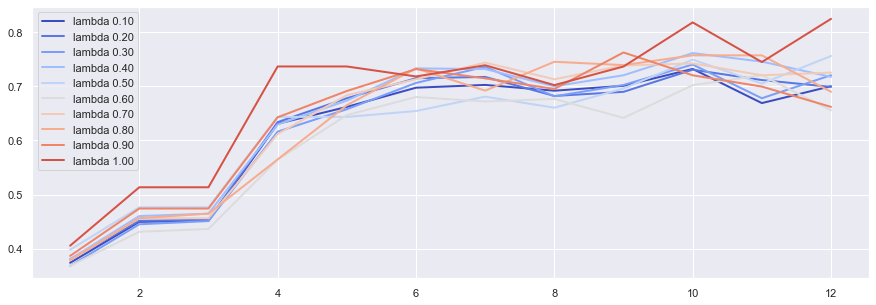

In [75]:
Result=deepcopy(Result01)
wid=126


Micro_f1_score=list()

X=range(1,13)

for Lambda in range(len(LAMBDA)):
    temp_list=[]
    for Max_depth in X:
        TrainData_test=LAMBDA[Lambda][1]
        data=TrainData_test[wid].drop('label',1)
        label=TrainData_test[wid].label
        estimator=Result[wid][Max_depth-1][1]
        temp_list.append( precision_recall_fscore_support(label, estimator.predict(data),average='macro')[2] )
    Micro_f1_score.append((Lambda,temp_list))

fig, ax = plt.subplots()
for Lambda,chart in Micro_f1_score:
    ax.plot(X,chart, linestyle='-', linewidth=2,c=color_map_color(Lambda),label=f"lambda {LAMBDA[Lambda][0]:.2f}")
ax.legend();
plt.show() 



C:\Users\hosse\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hosse\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hosse\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C

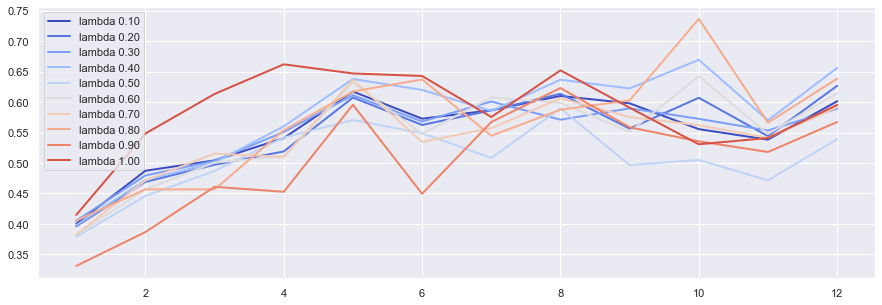

In [76]:
Result=deepcopy(Result025)
wid=126


Micro_f1_score=list()

X=range(1,13)

for Lambda in range(len(LAMBDA)):
    temp_list=[]
    for Max_depth in X:
        TrainData_test=LAMBDA[Lambda][1]
        data=TrainData_test[wid].drop('label',1)
        label=TrainData_test[wid].label
        estimator=Result[wid][Max_depth-1][1]
        temp_list.append( precision_recall_fscore_support(label, estimator.predict(data),average='macro')[2] )
    Micro_f1_score.append((Lambda,temp_list))

fig, ax = plt.subplots()
for Lambda,chart in Micro_f1_score:
    ax.plot(X,chart, linestyle='-', linewidth=2,c=color_map_color(Lambda),label=f"lambda {LAMBDA[Lambda][0]:.2f}")
ax.legend();
plt.show() 



In [50]:
wid=126
Max_depth=8
Lambda=7

TrainData_test=LAMBDA[Lambda][1]
print(f"step_forward parameter is : {LAMBDA[Lambda][0]} ")
data=TrainData_test[wid].drop('label',1)
label=TrainData_test[wid].label

estimator=Result[wid][Max_depth-1][1]
print(classification_report(label, estimator.predict(data)))

step_forward parameter is : 0.8 
                                precision    recall  f1-score   support

                           NAG       0.99      1.00      1.00      1545
 troca_faixa_direita_agressiva       1.00      0.25      0.40        12
troca_faixa_esquerda_agressiva       1.00      0.88      0.93         8

                      accuracy                           0.99      1565
                     macro avg       1.00      0.71      0.78      1565
                  weighted avg       0.99      0.99      0.99      1565



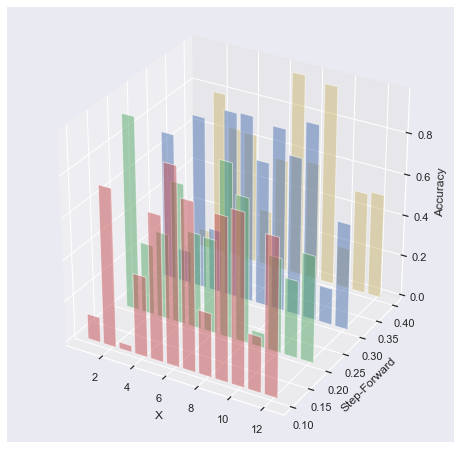

In [46]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
for c, z in zip(['r', 'g', 'b', 'y'], [x[0]for x in LAMBDA][0:4]):
    xs = np.arange(1,13)
    ys = np.random.rand(12)

    # You can provide either a single color or an array. To demonstrate this,
    # the first bar of each set will be colored cyan.
    cs = [c] * len(xs)
    ax.bar(xs, ys, zs=z, zdir='y', color=cs, alpha=0.5)

ax.set_xlabel('X')
ax.set_ylabel('Step-Forward')
ax.set_zlabel('Accuracy')

plt.show()
